### Import Packages

In [1]:
import os
import sys
import json
import inspect
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Data

In [2]:
df = pd.read_csv(os.path.join(data_dir, 'covariates_weekly.csv'))
df_year = df.copy()
df_year['Year_Week'] = df_year['Year_Week'].astype(str)
df_year['Year'] = df_year['Year_Week'].apply(lambda x: int(x.split('-')[0]))

# Drop rows where the year is 2008
df_no_2008 = df_year[df_year['Year'] != 2008].copy()

# Create a fold df
df_no_2008_fold = df_no_2008.copy()
df_no_2008_fold['Fold'] = df_no_2008_fold['Year'] - df_no_2008_fold['Year'].min() + 1

# Create pre and post 2008
df_pre = df_year[df_year['Year'] < 2008].copy()
df_post = df_year[df_year['Year'] > 2008].copy()

# Create fold for pre and post
df_pre_fold = df_pre.copy()
df_pre_fold['Fold'] = df_pre_fold['Year'] - df_pre_fold['Year'].min() + 1
df_post_fold = df_post.copy()
df_post_fold['Fold'] = df_post_fold['Year'] - df_post_fold['Year'].min() + 1

# Drop the year column
df_no_2008.drop('Year', axis=1, inplace=True)
df_no_2008_fold.drop('Year', axis=1, inplace=True)
df_pre.drop('Year', axis=1, inplace=True)
df_post.drop('Year', axis=1, inplace=True)
df_pre_fold.drop('Year', axis=1, inplace=True)
df_post_fold.drop('Year', axis=1, inplace=True)

### 1. Stepwise and Best Subset Selection¶

In [3]:
def forward_selection(X, y, criterion='aic', verbose=True):
    """ Perform forward feature selection based on AIC or BIC
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        criterion - 'aic' or 'bic' as the criterion for feature selection
        verbose - whether to print the sequence of inclusions
    Returns: tuple of (list of selected features, best model)
    """
    included = []
    current_score = float('inf')
    best_model = None

    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_score = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
            new_score[new_column] = model.aic if criterion == 'aic' else model.bic
        best_score = new_score.min()
        if new_score is not None and (len(included) == 0 or best_score < current_score):
            best_feature = new_score.idxmin()
            included.append(best_feature)
            current_score = best_score                        
            changed = True
            if verbose:
                print('Add  {:10} with {} {:.6}'.format(best_feature, criterion.upper(), best_score))
        if not changed:
            best_model = sm.OLS(y, sm.add_constant(X[included])).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
            break

    return included, best_model


def best_subset_selection(X, y, criterion='aic'):
    """ Perform best subset selection based on AIC or BIC
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        criterion - 'aic' or 'bic' for the selection criterion
    Returns: tuple of (best model, best features)
    """
    best_score = float('inf')
    best_model = None
    best_features = None

    # Iterate over all possible combinations of predictors
    for k in range(1, len(X.columns) + 1):
        for subset in itertools.combinations(X.columns, k):
            X_subset = sm.add_constant(X[list(subset)])
            model = sm.OLS(y, X_subset).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
            score = model.aic if criterion == 'aic' else model.bic
            if score < best_score:
                best_score = score
                best_model = model
                best_features = subset

    return best_features, best_model


def get_data(df):
    """ Extracts features (X) and target variables (Y) from the DataFrame for a specified phase.
    Parameters:
        df - The input DataFrame containing the data.
        phase (str) - The phase for which data is to be extracted.
    Returns: tuple: A tuple containing two DataFrames, features (X) and target variables (Y).
    """
    df_tmp = df.copy().dropna(axis=1)
    # Filter out covariates
    X_cols = df_tmp.columns.difference(['Year_Week', 'R1-RF', 'R2-RF', 'R3-RF', 'R4-RF', 'R5-RF'])
    X = df_tmp[X_cols].reset_index(drop=True)    
    # Use portfolio 1, 3 and 5
    Y = df_tmp[['R1-RF', 'R3-RF', 'R5-RF']].reset_index(drop=True)        
    return X, Y


#### 1.1 Naive forward selection and best subset selection

In [5]:
# Use 3 (low, mid, high) portfolio
num_pfos = 3
X, Y = get_data(df_no_2008)

# Forward selection AIC
forward_selected = {}
forward_models = {}
for p in range(num_pfos):
    y = Y.iloc[:, p]
    # Forward selection
    forward_features, forward_model = forward_selection(X, y, 'bic', verbose=False) 
    # Add the selected list of features to dictionary
    pfo_str = 'pfo' + '_' + str(2*p+1)
    forward_selected[pfo_str] = sorted(forward_features)
    forward_models[pfo_str] = forward_model
print(f"\n***Selected Features Using Forward Selection (AIC) ***\n")    
display(forward_selected)

# Forward selection BIC
forward_selected_bic = {}
forward_models_bic = {}
for p in range(num_pfos):
    y = Y.iloc[:, p]
    forward_features, forward_model = forward_selection(X, y, 'bic', verbose=False) 
    pfo_str = 'pfo' + '_' + str(2*p+1)
    forward_selected_bic[pfo_str] = sorted(forward_features)
    forward_models_bic[pfo_str] = forward_model
print(f"\n***Selected Features Using Forward Selection (BIC) ***\n")    
display(forward_selected_bic)

# Best subset selection AIC
best_selected = {}  
best_models = {}
for p in range(num_pfos):
    y = Y.iloc[:, p]
    best_features, best_model = best_subset_selection(X, y) 
    pfo_str = 'pfo' + '_' + str(2*p+1)
    best_selected[pfo_str] = sorted(list(best_features))
    best_models[pfo_str] = best_model
print(f"\n***Selected Features Using Best Subset Selection (AIC) ***\n")    
display(best_selected)

# Best subset selection BIC
best_selected_bic = {}  
best_models_bic = {}
for p in range(num_pfos):
    y = Y.iloc[:, p]
    best_features, best_model = best_subset_selection(X, y, 'bic') 
    pfo_str = 'pfo' + '_' + str(2*p+1)
    best_selected_bic[pfo_str] = sorted(list(best_features))
    best_models_bic[pfo_str] = best_model
print(f"\n***Selected Features Using Best Subset Selection (BIC) ***\n")    
display(best_selected_bic)


***Selected Features Using Forward Selection (AIC) ***



{'pfo_1': ['CMA', 'EG', 'HML', 'IA', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_3': ['CMA', 'EG', 'HML', 'IA', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_5': ['EG', 'HML', 'MOM', 'Mkt-RF', 'RMW', 'SMB']}


***Selected Features Using Forward Selection (BIC) ***



{'pfo_1': ['CMA', 'EG', 'HML', 'IA', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_3': ['CMA', 'EG', 'HML', 'IA', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_5': ['EG', 'HML', 'MOM', 'Mkt-RF', 'RMW', 'SMB']}


***Selected Features Using Best Subset Selection (AIC) ***



{'pfo_1': ['CMA', 'EG', 'HML', 'IA', 'ME', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_3': ['CMA', 'EG', 'HML', 'IA', 'ME', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_5': ['CMA', 'EG', 'HML', 'IA', 'ME', 'MOM', 'Mkt-RF', 'RMW', 'SMB']}


***Selected Features Using Best Subset Selection (BIC) ***



{'pfo_1': ['CMA', 'EG', 'HML', 'IA', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_3': ['CMA', 'EG', 'HML', 'IA', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_5': ['EG', 'HML', 'MOM', 'Mkt-RF', 'RMW', 'SMB']}

In [16]:
print("\n***Forward Selection Result***\n")
for pfo in forward_models.keys():
    print(forward_models[pfo].summary())

print("\n***Best Subset Selection Result***\n")
for pfo in best_models.keys():
    print(best_models[pfo].summary())


***Forward Selection Result***

                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     19.44
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           5.10e-25
Time:                        08:53:47   Log-Likelihood:                -2047.4
No. Observations:                1502   AIC:                             4111.
Df Residuals:                    1494   BIC:                             4153.
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.19

#### 1.2 Pre vs Post Best Subset Selection

In [20]:
# Best subset selection AIC (PRE)
num_pfos = 3
X, Y = get_data(df_pre)
best_selected = {}  
best_models_pre = {}
for p in range(num_pfos):
    y = Y.iloc[:, p]
    best_features, best_model = best_subset_selection(X, y) 
    pfo_str = 'pfo' + '_' + str(2*p+1)
    best_selected[pfo_str] = sorted(list(best_features))
    best_models_pre[pfo_str] = best_model
print(f"\n***Selected Features Using Best Subset Selection AIC (PRE) ***\n")    
display(best_selected)

# Best subset selection AIC (Post)
X, Y = get_data(df_post)
best_selected = {}  
best_models_post = {}
for p in range(num_pfos):
    y = Y.iloc[:, p]
    best_features, best_model = best_subset_selection(X, y) 
    pfo_str = 'pfo' + '_' + str(2*p+1)
    best_selected[pfo_str] = sorted(list(best_features))
    best_models_post[pfo_str] = best_model
print(f"\n***Selected Features Using Best Subset Selection AIC (POST) ***\n")    
display(best_selected)

print("\n***Pre 2008 Best Subset Selection Result***\n")
for pfo in best_models_pre.keys():
    print(best_models_pre[pfo].summary())

print("\n***Post 2008 Best Subset Selection Result***\n")
for pfo in best_models_post.keys():
    print(best_models_post[pfo].summary())


***Selected Features Using Best Subset Selection AIC (PRE) ***



{'pfo_1': ['CMA', 'HML', 'ME', 'MOM', 'Mkt-RF', 'ROE', 'SMB'],
 'pfo_3': ['CMA', 'EG', 'HML', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_5': ['CMA', 'EG', 'HML', 'ME', 'Mkt-RF', 'ROE', 'SMB']}


***Selected Features Using Best Subset Selection AIC (POST) ***



{'pfo_1': ['EG', 'HML', 'IA', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_3': ['EG', 'HML', 'IA', 'ME', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'pfo_5': ['EG', 'IA', 'MOM', 'Mkt-RF', 'RMW', 'SMB']}


***Pre 2008 Best Subset Selection Result***

                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     28.04
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           3.53e-34
Time:                        09:52:14   Log-Likelihood:                -655.76
No. Observations:                 724   AIC:                             1328.
Df Residuals:                     716   BIC:                             1364.
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const 

### 2. LASSO

#### 2.1 Lasso model selection: AIC-BIC (Pre 2008)

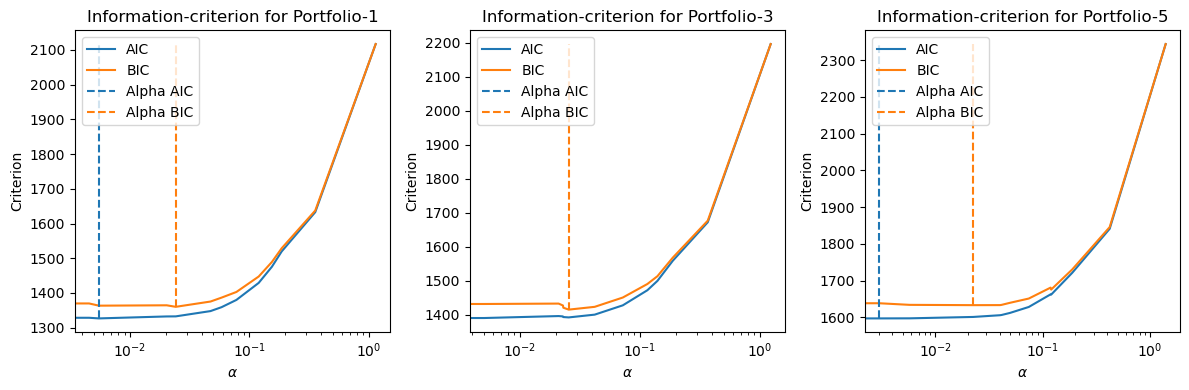

,PFO,Alpha AIC,Alpha BIC
0,pfo_1,0.005494,0.024171
1,pfo_3,0.000000,0.025550
2,pfo_5,0.003002,0.022553


In [53]:
X, Y = get_data(df_pre)
# Initialize an empty DataFrame to store all results
all_results = pd.DataFrame()
# DataFrame to store smallest alphas for each pfo
alpha_ic_pre = pd.DataFrame(columns=["PFO", "Alpha AIC", "Alpha BIC"])

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for pfo in range(3):
    y = Y.iloc[:, pfo]
    pfo_num = pfo*2 + 1
    # AIC
    lasso_lars_ic = make_pipeline(LassoLarsIC(criterion="aic")).fit(X, y)
    alpha_aic = lasso_lars_ic[-1].alpha_
    results_aic = pd.DataFrame({"alpha": lasso_lars_ic[-1].alphas_, 
                                "AIC": lasso_lars_ic[-1].criterion_})
    # BIC
    lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
    alpha_bic = lasso_lars_ic[-1].alpha_
    results_bic = pd.DataFrame({"alpha": lasso_lars_ic[-1].alphas_, 
                                "BIC": lasso_lars_ic[-1].criterion_})
    # Store the smallest alpha for AIC and BIC for this pfo
    alpha_ic_pre = alpha_ic_pre.append({"PFO": "pfo_" + str(pfo_num),
                                          "Alpha AIC": alpha_aic,
                                          "Alpha BIC": alpha_bic}, ignore_index=True)
    # Combine AIC and BIC results and add pfo column
    results_combined = pd.merge(results_aic, results_bic, on="alpha")
    results_combined["pfo"] = pfo
    all_results = pd.concat([all_results, results_combined], ignore_index=True)
    
    
    # Plot for this pfo
    axs[pfo].plot(results_combined["alpha"], results_combined["AIC"], label="AIC", linestyle="-", color="tab:blue")
    axs[pfo].plot(results_combined["alpha"], results_combined["BIC"], label="BIC", linestyle="-", color="tab:orange")
    axs[pfo].vlines(alpha_aic, results_combined["AIC"].min(), results_combined["AIC"].max(), label="Alpha AIC", color="tab:blue", linestyle="--")
    axs[pfo].vlines(alpha_bic, results_combined["BIC"].min(), results_combined["BIC"].max(), label="Alpha BIC", color="tab:orange", linestyle="--")
    axs[pfo].set_xlabel(r"$\alpha$")
    axs[pfo].set_ylabel("Criterion")
    axs[pfo].set_xscale("log")
    axs[pfo].legend()
    axs[pfo].set_title(f"Information-criterion for Portfolio-{pfo_num}")
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'alpha_ic_pre.png'))
plt.show()

# Display the alpha summary DataFrame
display(alpha_ic_pre)


#### Lasso model selection: AIC-BIC (Post 2008)

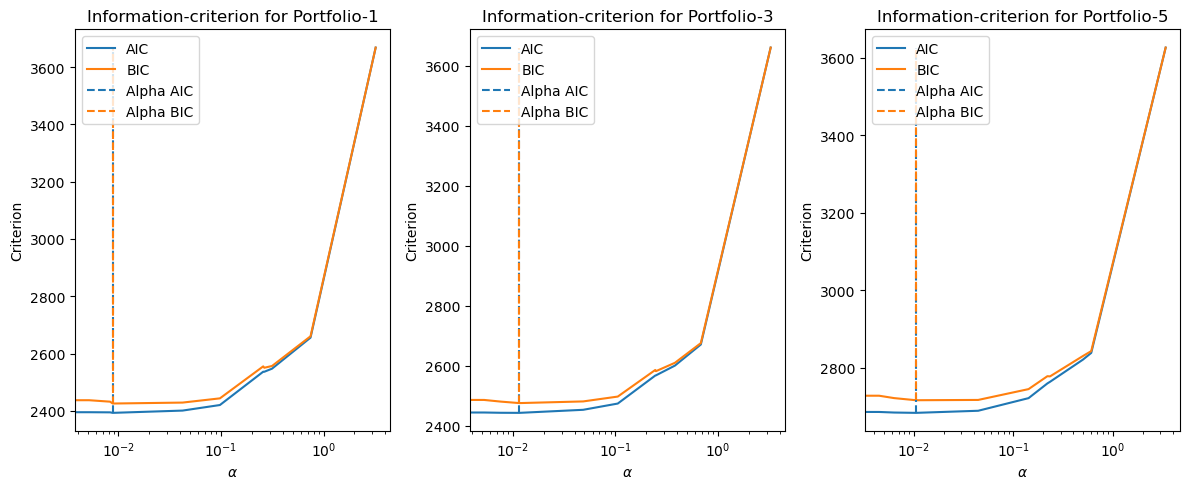

,PFO,Alpha AIC,Alpha BIC
0,pfo_1,0.008776,0.008776
1,pfo_3,0.011597,0.011597
2,pfo_5,0.010447,0.010447


In [46]:
X, Y = get_data(df_post)
# Initialize an empty DataFrame to store all results
all_results = pd.DataFrame()
# DataFrame to store smallest alphas for each pfo
alpha_ic_post = pd.DataFrame(columns=["PFO", "Alpha AIC", "Alpha BIC"])

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
for pfo in range(3):
    y = Y.iloc[:, pfo]
    pfo_num = pfo*2 + 1
    # AIC
    lasso_lars_ic = make_pipeline(LassoLarsIC(criterion="aic")).fit(X, y)
    alpha_aic = lasso_lars_ic[-1].alpha_
    results_aic = pd.DataFrame({"alpha": lasso_lars_ic[-1].alphas_, 
                                "AIC": lasso_lars_ic[-1].criterion_})
    # BIC
    lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
    alpha_bic = lasso_lars_ic[-1].alpha_
    results_bic = pd.DataFrame({"alpha": lasso_lars_ic[-1].alphas_, 
                                "BIC": lasso_lars_ic[-1].criterion_})
    # Store the smallest alpha for AIC and BIC for this pfo
    alpha_ic_post = alpha_ic_post.append({"PFO": "pfo_" + str(pfo_num),
                                          "Alpha AIC": alpha_aic,
                                          "Alpha BIC": alpha_bic}, ignore_index=True)
    # Combine AIC and BIC results and add pfo column
    results_combined = pd.merge(results_aic, results_bic, on="alpha")
    results_combined["pfo"] = pfo
    all_results = pd.concat([all_results, results_combined], ignore_index=True)
    # Plot for this pfo
    axs[pfo].plot(results_combined["alpha"], results_combined["AIC"], label="AIC", linestyle="-", color="tab:blue")
    axs[pfo].plot(results_combined["alpha"], results_combined["BIC"], label="BIC", linestyle="-", color="tab:orange")
    axs[pfo].vlines(alpha_aic, results_combined["AIC"].min(), results_combined["AIC"].max(), label="Alpha AIC", color="tab:blue", linestyle="--")
    axs[pfo].vlines(alpha_bic, results_combined["BIC"].min(), results_combined["BIC"].max(), label="Alpha BIC", color="tab:orange", linestyle="--")
    axs[pfo].set_xlabel(r"$\alpha$")
    axs[pfo].set_ylabel("Criterion")
    axs[pfo].set_xscale("log")
    axs[pfo].legend()
    axs[pfo].set_title(f"Information-criterion for Portfolio-{pfo_num}")
plt.tight_layout()
plt.show()

# Display the alpha summary DataFrame
display(alpha_ic_post)


#### 2.2 Lasso model selection: cross-validation

In [37]:
# Pre 2008
X, Y = get_data(df_pre_fold)
ps = PredefinedSplit(test_fold = X['Fold'])
X.drop(columns=['Fold'], inplace=True)
best_alphas = {}

# Calculate best alpha for lasso
for i, col in enumerate(Y.columns):
    lasso_cv = LassoCV(cv=ps).fit(X, Y[col])
    best_alphas['pfo'+'_'+str(2*i+1)] = lasso_cv.alpha_
alpha_cv_pre = pd.DataFrame(list(best_alphas.items()), columns=['PFO', 'Alpha CV Pre'])
display(alpha_cv_pre)


# Post 2008
X, Y = get_data(df_post_fold)
ps = PredefinedSplit(test_fold = X['Fold'])
X.drop(columns=['Fold'], inplace=True)
best_alphas = {}

# Calculate best alpha for lasso
for i, col in enumerate(Y.columns):
    lasso_cv = LassoCV(cv=ps).fit(X, Y[col])
    best_alphas['pfo'+'_'+str(2*i+1)] = lasso_cv.alpha_
alpha_cv_post = pd.DataFrame(list(best_alphas.items()), columns=['PFO', 'Alpha CV Post'])
display(alpha_cv_post)

,PFO,Alpha CV Pre
0,pfo_1,0.004607
1,pfo_3,0.040377
2,pfo_5,0.149793


,PFO,Alpha CV Post
0,pfo_1,0.130282
1,pfo_3,0.132207
2,pfo_5,0.012780


### Merge IC and CV result

In [56]:
# Pre 2008
alpha_pre = pd.merge(alpha_ic_pre, alpha_cv_pre, how='left', on='PFO')
alpha_pre['Max Alpha'] = alpha_pre[['Alpha AIC', 'Alpha BIC', 'Alpha CV Pre']].max(axis=1)
alpha_pre.columns = ['PFO', 'Alpha AIC Pre', 'Alpha BIC Pre', 'Alpha CV Pre', 'Max Alpha Pre']
print("\n***Lasso Hyperparameter Pre 2008***\n")
display(alpha_pre)

# Post 2008
alpha_post = pd.merge(alpha_ic_post, alpha_cv_post, how='left', on='PFO')
alpha_post['Max Alpha'] = alpha_post[['Alpha AIC', 'Alpha BIC', 'Alpha CV Post']].max(axis=1)
alpha_post.columns = ['PFO', 'Alpha AIC Post', 'Alpha BIC Post', 'Alpha CV Post', 'Max Alpha Post']
print("\n***Lasso Hyperparameter Post 2008***\n")
display(alpha_post)

# Create dictionary for hyperparameters:
best_alpha_dict_pre = alpha_pre.set_index('PFO')['Max Alpha Pre'].to_dict()
best_alpha_dict_post = alpha_post.set_index('PFO')['Max Alpha Post'].to_dict()


***Lasso Hyperparameter Pre 2008***



,PFO,Alpha AIC Pre,Alpha BIC Pre,Alpha CV Pre,Max Alpha Pre
0,pfo_1,0.005494,0.024171,0.004607,0.024171
1,pfo_3,0.000000,0.025550,0.040377,0.040377
2,pfo_5,0.003002,0.022553,0.149793,0.149793



***Lasso Hyperparameter Post 2008***



,PFO,Alpha AIC Post,Alpha BIC Post,Alpha CV Post,Max Alpha Post
0,pfo_1,0.008776,0.008776,0.130282,0.130282
1,pfo_3,0.011597,0.011597,0.132207,0.132207
2,pfo_5,0.010447,0.010447,0.012780,0.012780


#### 2.3 Run Lasso

In [81]:
def fit_lasso(X, Y, best_alpha_dict, num_pfo=3):
    lasso_selected = {}
    lasso_coefs = {}
    row_order = ['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'num Obs', 'alpha', 'adj-r-sqr']

    for p in range(num_pfo):
        # Get variables and best alpha
        pfo_str = 'pfo' + '_' + str(2*p+1)
        alpha = best_alpha_dict[pfo_str]

        # Fit Lasso and store coefficients
        lasso = Lasso(alpha=alpha).fit(X, Y.iloc[:, p])
        coef = pd.Series(data=lasso.coef_, index=X.columns)
        lasso_selected[pfo_str] = coef[coef != 0].index.tolist()

        # Add the intercept
        coef['const'] = lasso.intercept_
        lasso_coefs[pfo_str] = coef

        # Add r-squared and adjusted r-squared
        r2 = lasso.score(X, Y.iloc[:, p])
        n, p = X.shape[0], sum(lasso.coef_ != 0)
        adjusted_r2 = 1 - (1-r2) * (n-1) / (n-p-1)        
        coef['adj-r-sqr'] = adjusted_r2
        
        # Add Number of obs and alpha
        coef['num Obs'] = n
        coef['alpha'] = alpha

    # Convert coefficients to data frames
    lasso_coef_df = pd.DataFrame.from_dict(lasso_coefs)    
    lasso_coef_df = lasso_coef_df.loc[row_order]
    lasso_coef_df.replace(0, '-', inplace=True)
    return lasso_coef_df, lasso_selected

# Pre 2008
X, Y = get_data(df_pre)
lasso_coef_pre, lasso_selected_pre = fit_lasso(X, Y, best_alpha_dict_pre)
print("\n***Lasso Coefficients (Pre 2008)***\n")
display(lasso_coef_pre)

# Post 2008
X, Y = get_data(df_post)
lasso_coef_post, lasso_selected_post = fit_lasso(X, Y, best_alpha_dict_post)
print("\n***Lasso Coefficients (Post 2008)***\n")
display(lasso_coef_post)



***Lasso Coefficients (Pre 2008)***



,pfo_1,pfo_3,pfo_5
const,0.210309,0.441865,0.708915
Mkt-RF,0.305647,0.309682,0.262181
SMB,0.187264,0.172843,-
HML,0.116845,0.127917,0.043069
RMW,0.058829,0.033331,-
CMA,0.115096,0.082845,-
MOM,-0.013629,-,-
EG,-,-,-
ROE,0.000002,-,-
ME,-,-,0.123526



***Lasso Coefficients (Post 2008)***



,pfo_1,pfo_3,pfo_5
const,0.177381,0.37653,0.620469
Mkt-RF,0.490183,0.494667,0.522125
SMB,0.083892,0.115867,0.22364
HML,0.065434,0.054035,0.03681
RMW,0.238569,0.216638,0.427027
CMA,-,-,-
MOM,-,-,0.078892
EG,-0.173014,-0.150208,-0.33855
ROE,-,-,-
ME,-,-,-
